# Trade Data Exploration and Power BI Export

Now that my cleaned dataset is ready, this notebook will:
1. Perform exploratory data analysis (EDA)
2. Export the clean data for Power BI dashboard creation


In [2]:
# ======================================================
# Export Trade EDA - India vs Global (2020-2024)
# ======================================================

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker


In [3]:
# ------------------------------------------------------
# 1. Load Clean Data
# ------------------------------------------------------
processed_path = r"C:\Users\hp\Downloads\Project - export\New\Day 2- Data Gathering\data\processed"
df = pd.read_csv(os.path.join(processed_path, "Trade_Master.csv"))

print("✅ Data loaded successfully")
print(df.shape)
df.head()


✅ Data loaded successfully
(15061, 12)


,year,reporter_country,partner_country,trade_flow,trade_value_usd,hs_code,net_weight,product_name,origin,month,unit,quantity
0,2020,Albania,World,Export,3.927840e+07,121190,11187975.92,Ayurvedicherbs,Global,NaN,NaN,NaN
1,2020,Angola,World,Export,6.533650e+02,121190,106.03,Ayurvedicherbs,Global,NaN,NaN,NaN
2,2020,Azerbaijan,World,Export,1.455131e+06,121190,4288809.00,Ayurvedicherbs,Global,NaN,NaN,NaN
3,2020,Argentina,World,Export,1.270719e+06,121190,539168.25,Ayurvedicherbs,Global,NaN,NaN,NaN
4,2020,Australia,World,Export,1.659831e+07,121190,947672.76,Ayurvedicherbs,Global,NaN,NaN,NaN


In [4]:
#Data Overview

In [5]:
print("\n Basic info:")
print(df.info())
print("\n🧩 Missing Values:")
print(df.isna().sum())
print("\n📊 Data Types:")
print(df.dtypes)


 Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15061 entries, 0 to 15060
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              15061 non-null  int64  
 1   reporter_country  15061 non-null  object 
 2   partner_country   15061 non-null  object 
 3   trade_flow        15061 non-null  object 
 4   trade_value_usd   15061 non-null  float64
 5   hs_code           15061 non-null  int64  
 6   net_weight        15037 non-null  float64
 7   product_name      15061 non-null  object 
 8   origin            15061 non-null  object 
 9   month             13431 non-null  float64
 10  unit              13431 non-null  object 
 11  quantity          13431 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 1.4+ MB
None

🧩 Missing Values:
year                   0
reporter_country       0
partner_country        0
trade_flow             0
trade_value_usd        0
hs_code 

In [6]:
#Handling missing values

import numpy as np

# Compute mean net_weight per reporter_country and hs_code (for accurate imputation)
mean_weights = (
    df[df['net_weight'].notna()]
    .groupby(['reporter_country', 'hs_code'])['net_weight']
    .mean()
    .reset_index()
)

# Merge to bring the mean value for each missing combination
df = df.merge(mean_weights, on=['reporter_country', 'hs_code'], how='left', suffixes=('', '_mean'))

# Fill missing net_weight where origin == "Global"
df.loc[
    (df['origin'] == 'Global') & (df['net_weight'].isna()),
    'net_weight'
] = df.loc[
    (df['origin'] == 'Global') & (df['net_weight'].isna()),
    'net_weight_mean'
]

# Clean up helper column
df.drop(columns='net_weight_mean', inplace=True)


In [7]:
print("\n🧩 Missing Values:")
print (df[(df["net_weight"].isna())])


🧩 Missing Values:
     year reporter_country partner_country trade_flow  trade_value_usd  \
10   2020           Bhutan           World     Export      1338310.716   
301  2022           Bhutan           World     Export      2712749.403   
445  2023           Bhutan           World     Export       621067.990   

     hs_code  net_weight    product_name  origin  month unit  quantity  
10    121190         NaN  Ayurvedicherbs  Global    NaN  NaN       NaN  
301   121190         NaN  Ayurvedicherbs  Global    NaN  NaN       NaN  
445   121190         NaN  Ayurvedicherbs  Global    NaN  NaN       NaN  


In [8]:
# ---------------------------------------------------------------
# 3️⃣ DATA QUALITY CHECKS
# ---------------------------------------------------------------

# Check duplicates
duplicates = df.duplicated().sum()
print(f"\n Duplicate rows: {duplicates}")

# Check unique product and origin combinations
print("\n Products and origins:")
print(df.groupby(["product_name", "origin"]).size())


 Duplicate rows: 0

 Products and origins:
product_name    origin
Ayurvedicherbs  Global     689
                India     5511
Millet          Global     388
                India     2155
Turmeric        Global     553
                India     5765
dtype: int64


In [9]:
# ==========================================================
# 2️⃣ SUMMARY STATISTICS (HUMAN-READABLE)
# ==========================================================
summary = df[["trade_value_usd", "quantity", "net_weight"]].describe()

# Helper: convert large values to readable format
def human_readable(x):
    if x >= 1e9:
        return f"{x/1e9:.2f}B"
    elif x >= 1e6:
        return f"{x/1e6:.2f}M"
    elif x >= 1e3:
        return f"{x/1e3:.2f}K"
    else:
        return f"{x:.2f}"

summary_formatted = summary.map(
    lambda x: human_readable(x) if isinstance(x, (int, float)) else x
)
print("\n📈 Summary Statistics (Human Readable):")
print(summary_formatted)


📈 Summary Statistics (Human Readable):
      trade_value_usd quantity net_weight
count          15.06K   13.43K     15.06K
mean            1.83M  255.94K    654.78K
std            20.28M    1.25M      5.51M
min              0.20     0.13       0.00
25%             4.08K    1.50K      1.72K
50%            39.31K   20.00K     22.00K
75%           231.21K  100.00K    118.49K
max           888.04M   23.51M    177.79M


In [10]:
#Export Trends Over Time

In [33]:
trend = df[~((df['origin'] == 'India') & (df['partner_country'] == 'World'))]
trend.shape
trend.columns

Index(['year', 'reporter_country', 'partner_country', 'trade_flow',
       'trade_value_usd', 'hs_code', 'net_weight', 'product_name', 'origin',
       'month', 'unit', 'quantity'],
      dtype='object')

In [ ]:
powerbi_path = os.path.join(processed_path, "PowerBI")
os.makedirs(powerbi_path, exist_ok=True)

export_file = os.path.join(powerbi_path, "Trade_Master_PowerBI.csv")
trend.to_csv(export_file, index=False)

print("✅ Exported clean dataset for Power BI dashboard at:", export_file)


In [34]:
trend = trend[trend["origin"]=="India"]
print(trend)

       year reporter_country partner_country trade_flow  trade_value_usd  \
690    2020            India     Afghanistan     Export      1039311.022   
691    2020            India         Algeria     Export        14885.250   
692    2020            India          Angola     Export          364.811   
693    2020            India       Argentina     Export        47616.828   
694    2020            India       Australia     Export       302672.024   
...     ...              ...             ...        ...              ...   
15056  2024            India      Uzbekistan     Export       244411.399   
15057  2024            India       Venezuela     Export          969.475   
15058  2024            India           Yemen     Export       246854.300   
15059  2024            India          Zambia     Export          455.521   
15060  2024            India      Areas, Nes     Export        15812.206   

       hs_code  net_weight    product_name origin  month unit  quantity  
690     12119

In [35]:
# Select numeric columns only
num_cols = trend.select_dtypes(include='number').columns

# Function to detect outliers with IQR
def detect_outliers_iqr(data, cols):
    outlier_info = {}
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = data[(data[col] < lower) | (data[col] > upper)].shape[0]
        outlier_info[col] = {
            'Lower Bound': lower,
            'Upper Bound': upper,
            'Total Outliers': outliers
        }
    return pd.DataFrame(outlier_info).T

# Run outlier detection
outlier_report = detect_outliers_iqr(trend, num_cols)
print("🔍 OUTLIER REPORT:")
print(outlier_report)


🔍 OUTLIER REPORT:
                  Lower Bound   Upper Bound  Total Outliers
year               2018.00000    2026.00000             0.0
trade_value_usd -246015.43100  419061.21700          1759.0
hs_code           45790.00000  166430.00000             0.0
net_weight      -138332.18675  234212.31125          1634.0
month                -5.00000      19.00000             0.0
quantity        -138332.18675  234212.31125          1634.0


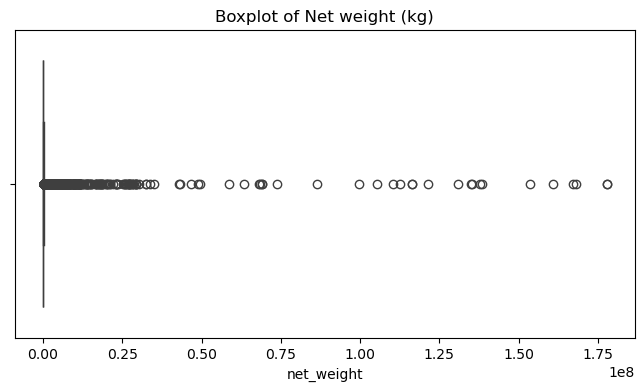

In [73]:
plt.figure(figsize=(8,4))
sns.boxplot(x=trend["net_weight"])
plt.title("Boxplot of Net weight (kg)")
plt.show()

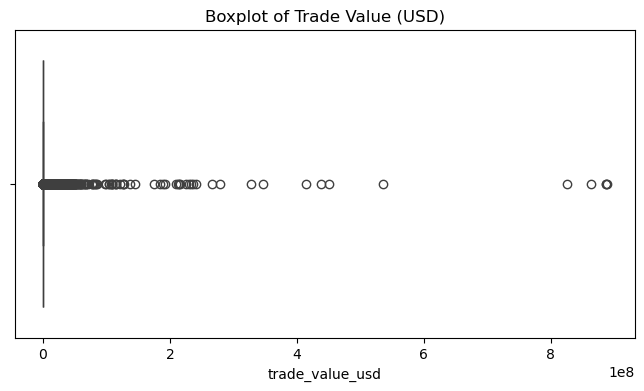

In [74]:
plt.figure(figsize=(8,4))
sns.boxplot(x=trend["trade_value_usd"])
plt.title("Boxplot of Trade Value (USD)")
plt.show()


In [77]:
Q1 = trend["trade_value_usd"].quantile(0.25)
Q3 = trend["trade_value_usd"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers_df = trend[(trend["trade_value_usd"] < lower) | (trend["trade_value_usd"] > upper)]
outliers_df


,year,reporter_country,partner_country,trade_flow,trade_value_usd,hs_code,net_weight,product_name,origin,month,unit,quantity
0,2020,Albania,World,Export,3.927840e+07,121190,1.118798e+07,Ayurvedicherbs,Global,NaN,NaN,NaN
2,2020,Azerbaijan,World,Export,1.455131e+06,121190,4.288809e+06,Ayurvedicherbs,Global,NaN,NaN,NaN
3,2020,Argentina,World,Export,1.270719e+06,121190,5.391682e+05,Ayurvedicherbs,Global,NaN,NaN,NaN
4,2020,Australia,World,Export,1.659831e+07,121190,9.476728e+05,Ayurvedicherbs,Global,NaN,NaN,NaN
5,2020,Austria,World,Export,5.540101e+07,121190,9.610282e+06,Ayurvedicherbs,Global,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15019,2024,India,Netherlands,Export,7.163191e+05,91030,2.537030e+05,Turmeric,India,12.0,Kg,253703.0
15030,2024,India,Saudi Arabia,Export,9.541836e+05,91030,5.457450e+05,Turmeric,India,12.0,Kg,545745.0
15047,2024,India,United Arab Emirates,Export,2.696708e+06,91030,1.573090e+06,Turmeric,India,12.0,Kg,1573090.0
15052,2024,India,United Kingdom,Export,1.171275e+06,91030,4.462500e+05,Turmeric,India,12.0,Kg,446250.0


In [78]:
trend.columns

Index(['year', 'reporter_country', 'partner_country', 'trade_flow',
       'trade_value_usd', 'hs_code', 'net_weight', 'product_name', 'origin',
       'month', 'unit', 'quantity'],
      dtype='object')

In [ ]:
#Python Code to Categorize Net Weight by Range

In [88]:
df = trend

def detect_unit(weight):
    if weight <= 0:
        return "Invalid"
    elif weight < 50:
        return "Small KG"
    elif weight < 10000:
        return "Normal KG"
    elif weight < 100000:
        return "Probably Tons (10–100 tons)"
    elif weight < 500000:
        return "High Tons (100–500 tons)"
    else:
        return "Impossible / Wrong Unit"

df['weight_flag'] = df['net_weight'].apply(detect_unit)

df['weight_flag'].value_counts()


weight_flag
Normal KG                      4969
Probably Tons (10–100 tons)    4925
High Tons (100–500 tons)       2642
Impossible / Wrong Unit        1376
Small KG                        961
Invalid                           8
Name: count, dtype: int64

In [89]:
x = df[(df['weight_flag']=="Impossible / Wrong Unit")]

In [90]:
print (x["net_weight"])

0        1.118798e+07
2        4.288809e+06
3        5.391682e+05
4        9.476728e+05
5        9.610282e+06
             ...     
15010    8.717270e+05
15015    1.403850e+06
15030    5.457450e+05
15047    1.573090e+06
15054    7.427660e+05
Name: net_weight, Length: 1376, dtype: float64


In [93]:
y = df[(df['weight_flag']=="Invalid")]

In [95]:
y

,year,reporter_country,partner_country,trade_flow,trade_value_usd,hs_code,net_weight,product_name,origin,month,unit,quantity,weight_flag
30,2020,Cyprus,World,Export,3.080971e+05,121190,0.0,Ayurvedicherbs,Global,NaN,NaN,NaN,Invalid
48,2020,Guatemala,World,Export,1.612527e+06,121190,0.0,Ayurvedicherbs,Global,NaN,NaN,NaN,Invalid
63,2020,Jordan,World,Export,8.983354e+05,121190,0.0,Ayurvedicherbs,Global,NaN,NaN,NaN,Invalid
120,2020,Spain,World,Export,1.031531e+08,121190,0.0,Ayurvedicherbs,Global,NaN,NaN,NaN,Invalid
168,2021,Colombia,World,Export,3.481892e+07,121190,0.0,Ayurvedicherbs,Global,NaN,NaN,NaN,Invalid
267,2021,Spain,World,Export,1.081021e+08,121190,0.0,Ayurvedicherbs,Global,NaN,NaN,NaN,Invalid
8797,2020,Jordan,World,Export,2.763860e+05,91030,0.0,Turmeric,Global,NaN,NaN,NaN,Invalid
8834,2020,Singapore,World,Export,4.022435e+05,91030,0.0,Turmeric,Global,NaN,NaN,NaN,Invalid


In [94]:
print (y["net_weight"])

30      0.0
48      0.0
63      0.0
120     0.0
168     0.0
267     0.0
8797    0.0
8834    0.0
Name: net_weight, dtype: float64


In [91]:
x.shape

(1376, 13)

In [92]:
df['net_weight'].sort_values(ascending=False).head(20)

8833    1.777882e+08
9274    1.777377e+08
6352    1.679702e+08
9177    1.672806e+08
9063    1.607438e+08
8950    1.535508e+08
315     1.385337e+08
461     1.377300e+08
24      1.352889e+08
598     1.349338e+08
167     1.309658e+08
665     1.213881e+08
260     1.163903e+08
6268    1.162708e+08
6581    1.125401e+08
113     1.104873e+08
403     1.054569e+08
547     9.977806e+07
6498    8.651485e+07
6273    7.389496e+07
Name: net_weight, dtype: float64

In [ ]:
#Correlation

In [96]:
import pandas as pd

# Select numeric columns automatically
num_cols = trend.select_dtypes(include=['int64','float64'])

# Pearson correlation matrix
pearson_corr = num_cols.corr(method='pearson')

# Spearman correlation matrix
spearman_corr = num_cols.corr(method='spearman')

pearson_corr, spearman_corr


(                     year  trade_value_usd   hs_code  net_weight     month  \
 year             1.000000         0.006567  0.000787    0.000066 -0.013576   
 trade_value_usd  0.006567         1.000000  0.065902    0.732735  0.002573   
 hs_code          0.000787         0.065902  1.000000    0.022459 -0.004504   
 net_weight       0.000066         0.732735  0.022459    1.000000 -0.005089   
 month           -0.013576         0.002573 -0.004504   -0.005089  1.000000   
 quantity         0.011090         0.665128 -0.059481    1.000000 -0.005089   
 
                  quantity  
 year             0.011090  
 trade_value_usd  0.665128  
 hs_code         -0.059481  
 net_weight       1.000000  
 month           -0.005089  
 quantity         1.000000  ,
                      year  trade_value_usd   hs_code  net_weight     month  \
 year             1.000000         0.046400  0.003500    0.013245 -0.013679   
 trade_value_usd  0.046400         1.000000  0.078998    0.935157  0.004538   
 hs_

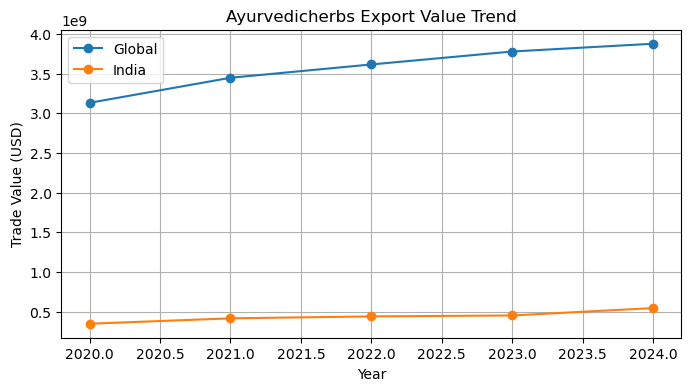

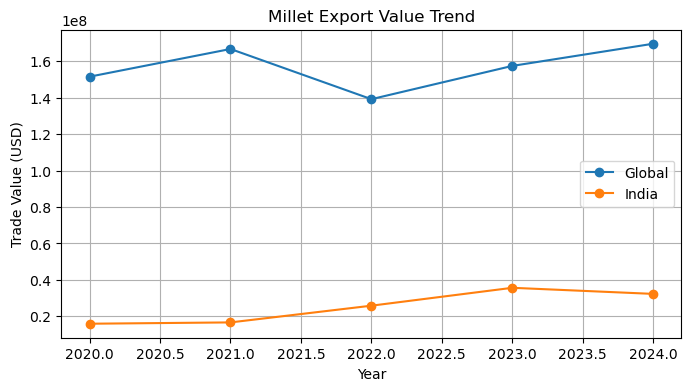

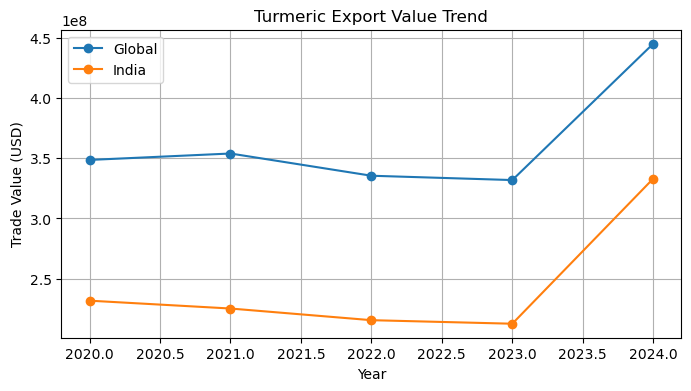

In [57]:
trend = trend.groupby(["year", "product_name", "origin"])["trade_value_usd"].sum().reset_index()

for product in trend["product_name"].unique():
    plt.figure(figsize=(8, 4))
    temp = trend[trend["product_name"] == product]
    for origin in temp["origin"].unique():
        subset = temp[temp["origin"] == origin]
        plt.plot(subset["year"], subset["trade_value_usd"], marker="o", label=origin)
    plt.title(f"{product} Export Value Trend")
    plt.xlabel("Year")
    plt.ylabel("Trade Value (USD)")
    plt.legend()
    plt.grid(True)
    plt.savefig(r'C:\Users\hp\Downloads\Project - export\New\Day 2- Data Gathering\Notebooks\pic.png')
    plt.show()
    
